In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as po
import matplotlib.pyplot as plt
po.init_notebook_mode(connected=True)
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('forex.csv', parse_dates=['date']).set_index('date')
df.head()

slug     open    high     low   close currency
date                                                         
2001-04-10  GBP/EGP  5.58090  5.5947  5.5947  5.5947      EGP
2001-06-04  GBP/EGP  5.47517  5.4939  5.4939  5.4939      EGP
2001-08-01  GBP/EGP  5.67990  5.6543  5.6543  5.6543      EGP
2002-07-29  GBP/EGP  7.21700  7.2170  7.2170  7.2170      EGP
2003-01-02  GBP/EGP  7.42429  7.3899  7.3899  7.3899      EGP

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1453035 entries, 2001-04-10 to 2021-08-30
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   slug      1453035 non-null  object 
 1   open      1453035 non-null  float64
 2   high      1453035 non-null  float64
 3   low       1453035 non-null  float64
 4   close     1453035 non-null  float64
 5   currency  1453035 non-null  object 
dtypes: float64(4), object(2)
memory usage: 77.6+ MB


In [4]:
import functions as fn

In [5]:
inr = fn.select('INR')
inr.head()

The number of unique exchange (slug) is 5


slug     open     high      low    close currency
date                                                            
2003-12-01  JPY/INR  0.41586  0.41902  0.41561  0.41892      INR
2003-12-02  JPY/INR  0.41872  0.42036  0.41500  0.41948      INR
2003-12-03  JPY/INR  0.41962  0.42152  0.41863  0.42044      INR
2003-12-04  JPY/INR  0.42035  0.42190  0.41948  0.42070      INR
2003-12-05  JPY/INR  0.42082  0.42350  0.41947  0.42350      INR

In [6]:
uniq_exchng = inr['slug'].unique()

In [7]:
df_map = inr['slug'].unique().tolist()
df_lst = [inr[inr['slug'] == x ]for x in uniq_exchng]
# print(df_lst)

In [8]:
x = 0
for df in df_lst:
        fig = go.Figure()
        fig.add_trace(go.Ohlc(x=df.index, 
                open=df.open,
                high=df.high,
                low=df.low,
                close=df.close,
                name='Price'))
        fig.update(layout_xaxis_rangeslider_visible=False, layout_width=1000,
                   layout_title=df_map[x])
        x += 1
        fig.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_lst[2]['close'])
print(f'ADF Statistics: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used: {adf_result[3]}')
print('Critical Values')
for k,v in adf_result[4].items():
    print(f'  {k}: {v}')

ADF Statistics: -1.0111347716556436
p-value: 0.749181515509371
No. of lags used: 26
No. of observations used: 4554
Critical Values
  1%: -3.4317867566579885
  5%: -2.8621748773963054
  10%: -2.5671079483575707


In [10]:
def stationary_check(lst):
    x = 0
    for df in lst:
        adf_result = adfuller(df['close'])
        if adf_result[1] < 0.05:
            print(f'For {df_map[x]} the series is Stationary')
        else:
            print(f'For {df_map[x]} the series is Non-Stationary')
        x += 1

In [11]:
stationary_check(df_lst)

For JPY/INR the series is Non-Stationary
For CHF/INR the series is Non-Stationary
For EUR/INR the series is Non-Stationary
For GBP/INR the series is Non-Stationary
For USD/INR the series is Non-Stationary


In [12]:
stat_df_lst = []
for df in df_lst:
    dd = df.drop(columns=['slug', 'currency'])
    adf_result = adfuller(dd['close'])
    if adf_result[1] > 0.05:
        df_log = np.log(dd)
        df_diff = df_log.diff().bfill()
        stat_df_lst.append(df_diff)
    else:
        stat_df_lst.append(dd)

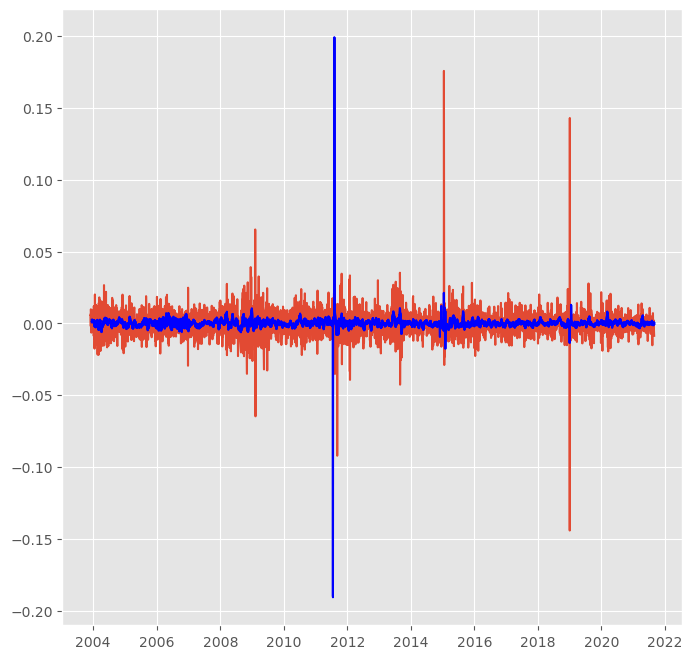

In [13]:
plt.plot(stat_df_lst[1].index, stat_df_lst[1].close, '-')
plt.plot(stat_df_lst[1].rolling(12).mean(), color='blue')
plt.show()

In [14]:
from prophet import Prophet

In [15]:
new = stat_df_lst[0][['close']]
new.head()

close
date                
2003-12-01  0.001336
2003-12-02  0.001336
2003-12-03  0.002286
2003-12-04  0.000618
2003-12-05  0.006634

In [16]:
train_data1, test_data1 = new[3:int(len(new)*0.9)], new[int(len(new)*0.9):]

In [17]:
# train_data1 = new.sample(frac=0.7, random_state=2)
# test_data1 = new.drop(train_data1.index)

In [18]:
train_data = train_data1.reset_index().rename(columns={'date': 'ds', 'close': 'y'})
test_data = test_data1.reset_index().rename(columns={'date': 'ds', 'close': 'y'})

In [19]:
print(f'Training data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Training data shape: (4119, 2)
Test data shape: (459, 2)


In [20]:
model = Prophet(seasonality_mode='additive', daily_seasonality=True)
model.fit(train_data)

17:45:12 - cmdstanpy - INFO - Chain [1] start processing
17:45:13 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
future = test_data[['ds']]
forecast = model.predict(future)

In [22]:
forecast.head()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-11-27  0.000546   -0.011533    0.010513     0.000546     0.000546   
1 2019-11-28  0.000546   -0.011631    0.010261     0.000546     0.000546   
2 2019-11-29  0.000546   -0.011886    0.009765     0.000546     0.000546   
3 2019-12-02  0.000546   -0.011556    0.009345     0.000546     0.000546   
4 2019-12-03  0.000546   -0.009867    0.011637     0.000546     0.000546   

   additive_terms  additive_terms_lower  additive_terms_upper    daily  ...  \
0       -0.000904             -0.000904             -0.000904 -0.00048  ...   
1       -0.000980             -0.000980             -0.000980 -0.00048  ...   
2       -0.001897             -0.001897             -0.001897 -0.00048  ...   
3       -0.001446             -0.001446             -0.001446 -0.00048  ...   
4       -0.000030             -0.000030             -0.000030 -0.00048  ...   

     weekly  weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0 -0.000161     -0.000161     -0.000161 -0.000262     -0.000262     -0.000262   
1 -0.000136     -0.000136     -0.000136 -0.000364     -0.000364     -0.000364   
2 -0.000949     -0.000949     -0.000949 -0.000468     -0.000468     -0.000468   
3 -0.000191     -0.000191     -0.000191 -0.000775     -0.000775     -0.000775   
4  0.001318      0.001318      0.001318 -0.000868     -0.000868     -0.000868   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper      yhat  
0                         0.0 -0.000358  
1                         0.0 -0.000434  
2                         0.0 -0.001351  
3                         0.0 -0.000901  
4                         0.0  0.000515  

[5 rows x 22 columns]

In [23]:
test_data_cop = test_data.copy()
test_data_cop['pred'] = forecast['yhat']
test_data_cop.set_index('ds', inplace=True)

In [24]:
train_data1 = train_data.set_index('ds')
test_data1 = test_data.set_index('ds')
fore = forecast[['ds', 'yhat']].set_index('ds')


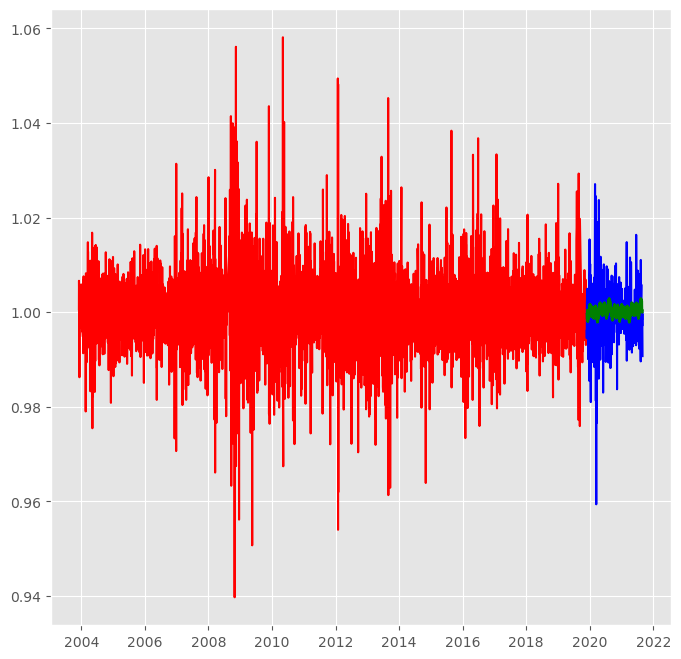

In [25]:
plt.plot(np.exp(train_data1['y']), c='r')
plt.plot(np.exp(test_data1['y']), c='b')
plt.plot(np.exp(fore['yhat']), c='g')
plt.show()

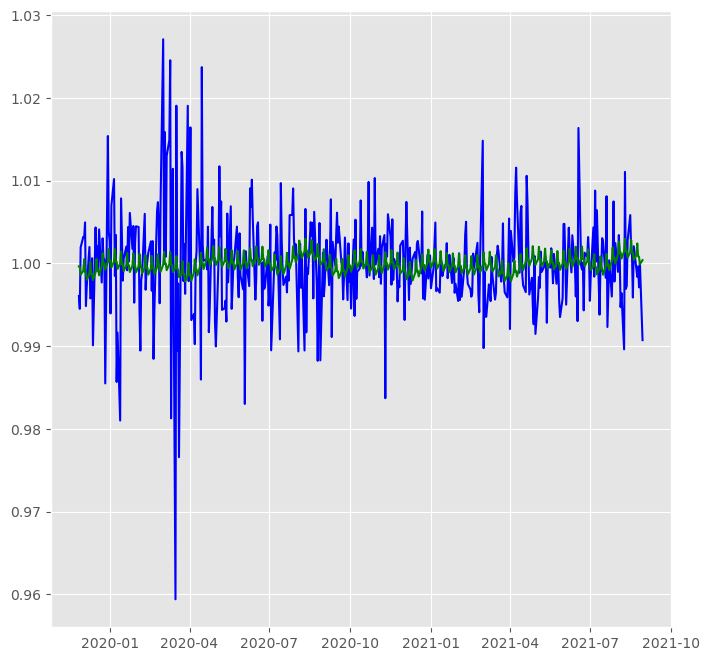

In [26]:
# plt.plot(np.exp(train_data1['y']), c='r')
plt.plot(np.exp(test_data_cop['y']), c='b')
plt.plot(np.exp(test_data_cop['pred']), c='g')
plt.show()

In [27]:
# model.plot(forecast)
# plt.show()

In [28]:
# model.plot_components(forecast)
# plt.show()

In [29]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def MAPE(y, y_hat):
    return np.mean(np.abs((y - y_hat))/y) * 100

def RMSE(y, y_hat):
    return np.sqrt(np.mean(np.square(y - y_hat)))


print(mean_absolute_percentage_error(test_data['y'], forecast['yhat']))
print(np.sqrt(mean_squared_error(test_data['y'], forecast['yhat'])))

1.538066440329851
0.006193161668407285


In [30]:
new_mul = df_lst[0].reset_index().drop(columns=['slug', 'currency', 'open'])
new_mul = new_mul.rename(columns={'date': 'ds', 'high': 'add2', 
                                  'low': 'add3', 'close': 'y'})

In [31]:
mul_train_data = new_mul.sample(frac=0.7, random_state=2)
mul_test_data = new_mul.drop(mul_train_data.index)

In [32]:
n_model = Prophet(seasonality_mode='additive', daily_seasonality=True)
n_model.add_regressor('add2')
n_model.add_regressor('add3')
n_model.fit(mul_train_data)
future = mul_test_data.drop('y', axis=1)
n_forecast = n_model.predict(future)

17:45:16 - cmdstanpy - INFO - Chain [1] start processing
17:45:19 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
print(MAPE(mul_test_data['y'], n_forecast['yhat']))
print(RMSE(mul_test_data['y'], n_forecast['yhat']))

40.19304187591506
0.18065200217535338


In [34]:
mul_test_data_cop = mul_test_data.copy()
mul_test_data_cop['pred'] = n_forecast['yhat']
mul_test_data_cop.set_index('ds', inplace=True)
mul_test_data_cop.head()

add2     add3        y      pred
ds                                             
2003-12-01  0.41902  0.41561  0.41892  0.417621
2003-12-02  0.42036  0.41500  0.41948  0.418902
2003-12-12  0.42234  0.42022  0.42147  0.425401
2003-12-15  0.42478  0.41983  0.42225  0.425327
2003-12-17  0.42394  0.42075  0.42254  0.427029

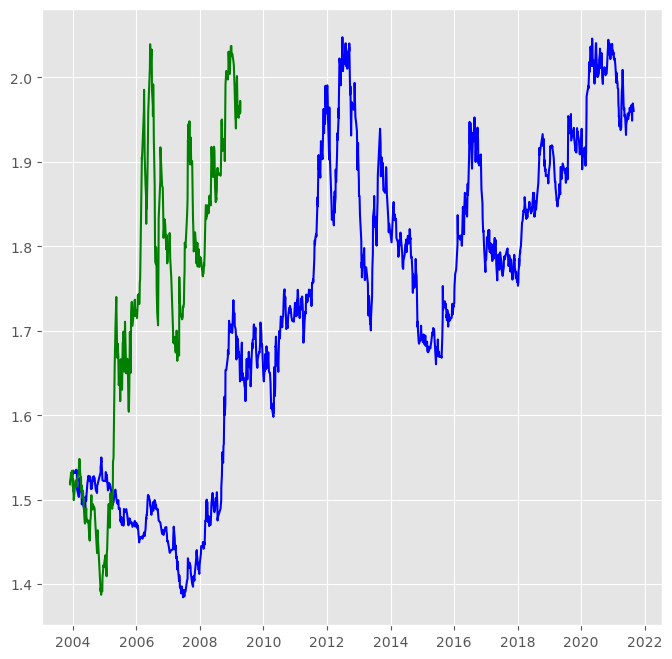

In [35]:
plt.plot(np.exp(mul_test_data_cop['y']), c='b')
plt.plot(np.exp(mul_test_data_cop['pred']), c='g')
plt.show()

In [36]:
# n_model.plot(n_forecast)
# plt.show()

In [37]:
# n_model.plot_components(n_forecast)
# plt.show()

In [38]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

diff = stat_df_lst[0][['close']]
diff = diff.resample('M').sum()

# # ACF
# plot_acf(diff, lags= range(0, 20))
# plt.show()

# # PACF
# plot_pacf(diff, lags= range(0, 20),)
# plt.show()

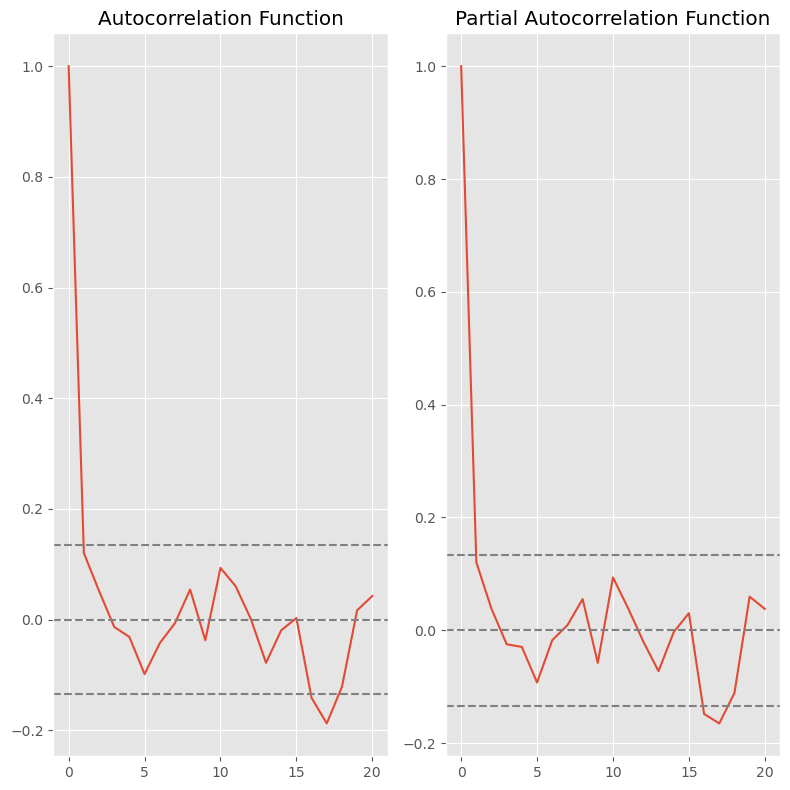

In [39]:
#ACF & PACF plots

lag_acf = acf(diff, nlags=20)
lag_pacf = pacf(diff, nlags=20, method='ols')

#Plot ACF: (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF: (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 
plt.show()

RSS: 0.3047


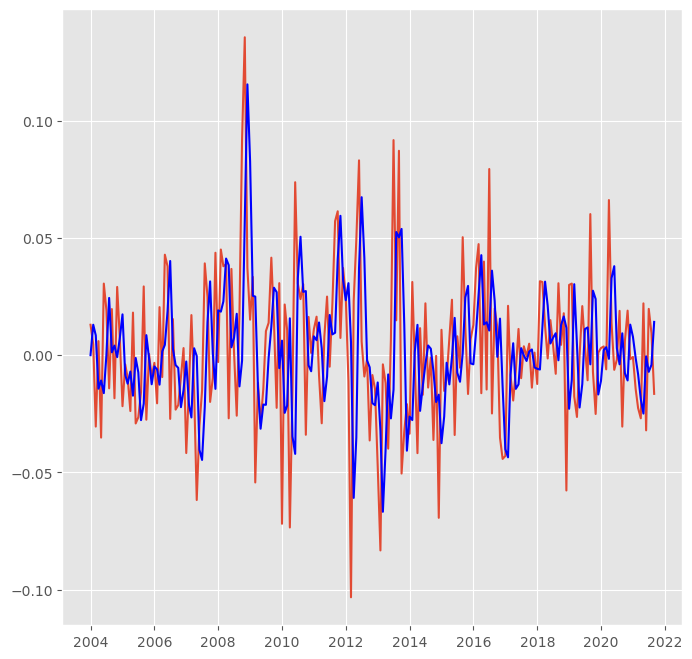

In [40]:
# AR MA and ARIMA
from statsmodels.tsa.arima.model import ARIMA
#(p,d,q)

AR_model = ARIMA(diff, order=(1,1,0))
AR_model_results = AR_model.fit()
plt.plot(diff)
plt.plot(AR_model_results.fittedvalues, color='blue')
print('RSS: %.4f'%sum((AR_model_results.fittedvalues - diff['close'])**2))
plt.show()


RSS: 0.2243


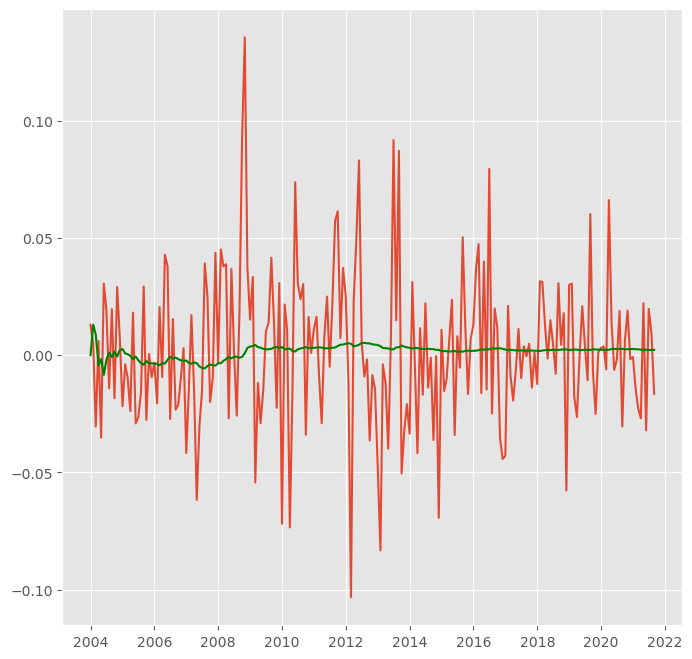

In [41]:
MA_model = ARIMA(diff, order=(0,1,1))
MA_model_results = MA_model.fit()
plt.plot(diff)
plt.plot(MA_model_results.fittedvalues, color='g')
print('RSS: %.4f'%sum((MA_model_results.fittedvalues - diff['close'])**2))
plt.show()

RSS: 0.2210


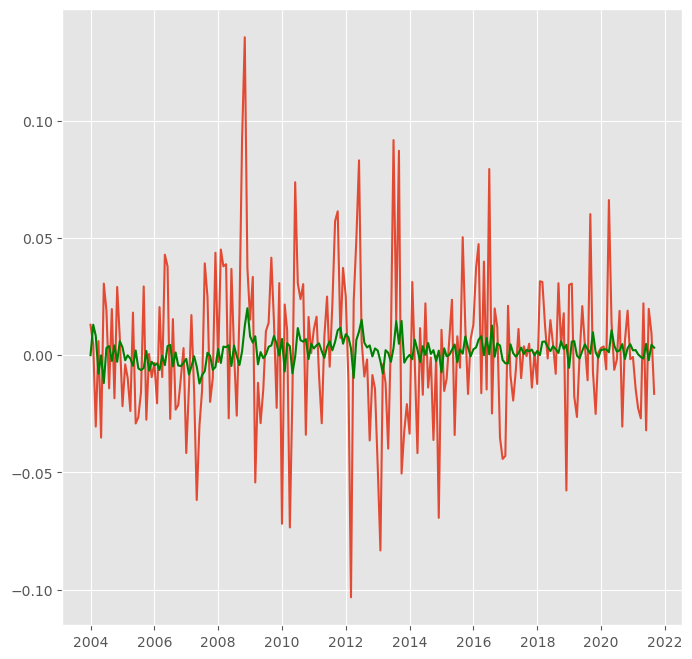

In [42]:
ARIMA_model = ARIMA(diff, order=(1,1,1))
ARIMA_results = ARIMA_model.fit()
plt.plot(diff)
plt.plot(ARIMA_results.fittedvalues, color='g')
print('RSS: %.4f'%sum((ARIMA_results.fittedvalues - diff['close'])**2))
plt.show()